In [ ]:
import numpy as np

# 1. F = G*m1*m2/(r+h)^2 exterior; interior (h<0): F = G*m1*m2*(r+h)/r^3
def calc_force(m1:float, m2: float, r: float, h: float) -> float:
    """
    Calculates the gravitational pull made by an object.
    Returns F (Newtons).
    """
    G = 6.674e-11
    R = r + h
    if R <= 0:
        return 0.0  # fuera del dominio físico
    if h >= 0:
        return G * m1 * m2 / (R**2)          
    else:
        return G * m1 * m2 * (R) / (r**3)    

# 2.Parameters
samples = 1000

# Generate our sintetic data
m1 = np.random.uniform(1e20, 1e24, samples)  # more massive object
m2 = np.random.uniform(1+1e-10, 1e5, samples)      # less massive object
r  = np.random.uniform(1e4, 1e6, samples)    # planet radius
h  = np.random.uniform(-r+1e-9 + 1e-9, 2000, samples)  # height, with R>0

data = []
for i in range(samples):
    f = calc_force(m1[i], m2[i], r[i], h[i])
    data.append([m1[i], m2[i], r[i], h[i], f])

# convert to np for AI model
data = np.array(data)
print(data[:5])

from sklearn.model_selection import train_test_split

# split into train/validation 80% and test 20%
train_val_set, test_set = train_test_split(data, test_size=0.2)

# From the train/validation set, segregate between train 80% and validation 20%
train_set, val_set = train_test_split(train_val_set, test_size=0.2)

# split into x and y  (using 3 transformed features [log m1, log m2, z] from the original 4)
EPS = 1e-12
m1_tr, m2_tr, r_tr, h_tr, F_tr = train_set[:,0], train_set[:,1], train_set[:,2], train_set[:,3], train_set[:,4]
m1_va, m2_va, r_va, h_va, F_va = val_set[:,0],   val_set[:,1],   val_set[:,2],   val_set[:,3],   val_set[:,4]
m1_te, m2_te, r_te, h_te, F_te = test_set[:,0],  test_set[:,1],  test_set[:,2],  test_set[:,3],  test_set[:,4]

R_tr = np.maximum(r_tr + h_tr, 1e-9)
R_va = np.maximum(r_va + h_va, 1e-9)
R_te = np.maximum(r_te + h_te, 1e-9)

# z = -2*logR (exterior) ; z = logR - 3*logr (interior)
z_tr = np.where(h_tr >= 0, -2*np.log(R_tr), np.log(R_tr) - 3*np.log(r_tr))
z_va = np.where(h_va >= 0, -2*np.log(R_va), np.log(R_va) - 3*np.log(r_va))
z_te = np.where(h_te >= 0, -2*np.log(R_te), np.log(R_te) - 3*np.log(r_te))

# features = [log m1, log m2, z]  
x_train = np.stack([np.log(m1_tr), np.log(m2_tr), z_tr], axis=1)
x_val   = np.stack([np.log(m1_va), np.log(m2_va), z_va], axis=1)
x_test  = np.stack([np.log(m1_te), np.log(m2_te), z_te], axis=1)

# Target en log (coherente)
y_train = np.log(F_tr.reshape(-1,1))
y_val   = np.log(F_va.reshape(-1,1))
y_test  = np.log(F_te.reshape(-1,1))

from sklearn.preprocessing import StandardScaler

# 3.Data preprocessing — escalar los LOGS
x_scaler = StandardScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_val_scaled   = x_scaler.transform(x_val)
x_test_scaled  = x_scaler.transform(x_test)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_val_scaled   = y_scaler.transform(y_val)
y_test_scaled  = y_scaler.transform(y_test)

# 4.Designing our model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

def build_functional_model(input_dim):
    """ Build a 4-layer MLP """
    inputs = Input(shape=(input_dim,), name="input_layer")
    x = Dense(20, activation="relu", name="hidden_layer_1")(inputs)
    outputs = Dense(1, activation="linear", name="output_layer")(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# 5. Compile the model
input_dim = 3  # [log m1, log m2, z = -2*logR // z = logR - 3*logr]
model = build_functional_model(input_dim)
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

history = model.fit(x=x_train_scaled, y=y_train_scaled, validation_data=(x_val_scaled, y_val_scaled), epochs=15)

[[ 6.52864653e+23  7.08651340e+04  2.02524267e+04 -1.75224600e+04
   1.01477117e+09]
 [ 5.34054444e+23  6.00394413e+04  5.33839389e+05 -1.94619363e+04
   7.23533188e+06]
 [ 3.55161739e+23  9.68348444e+04  7.15761250e+05 -6.52915998e+05
   3.93379712e+05]
 [ 5.08440227e+23  6.39231881e+04  2.20733501e+05 -1.43207698e+05
   1.56360139e+07]
 [ 4.76991399e+23  2.85584925e+04  8.76963633e+05 -6.70205315e+05
   2.78708535e+05]]
Epoch 1/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1160 - mae: 0.8238 - val_loss: 0.9982 - val_mae: 0.7672
Epoch 2/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7805 - mae: 0.6852 - val_loss: 0.6838 - val_mae: 0.6313
Epoch 3/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5248 - mae: 0.5537 - val_loss: 0.4423 - val_mae: 0.5042
Epoch 4/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3344 - mae: 0.4344 - val_loss: 0.2723 - val_mae: 0.3909
Epoch 5/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2037 - mae: 0.3323 - val_loss: 0.1602 - val_mae: 

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


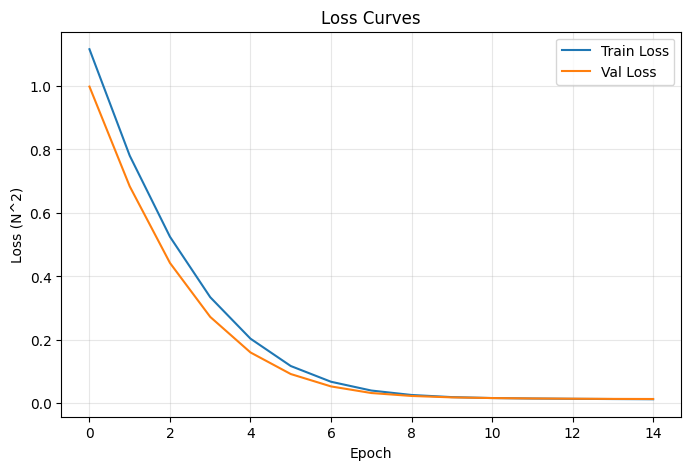

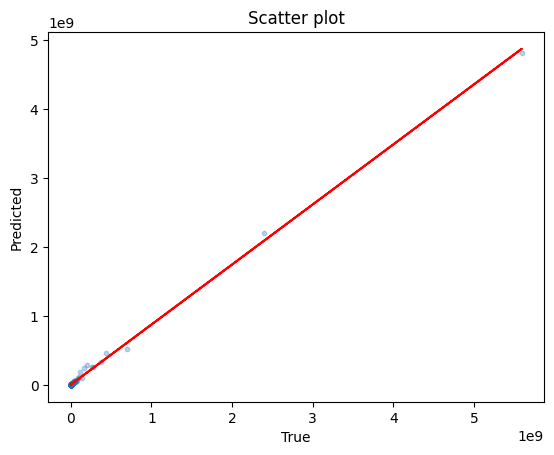

{'mae': 8424973.249479424, 'medianae': 279603.80150501453, 'mse': 3389899123469437.5, 'r2': 0.9978707094332494, 'mape': 0.23331575034848956, 'mspe': np.float64(0.11446249269319182), 'medianape': np.float64(0.16048322608184792)}


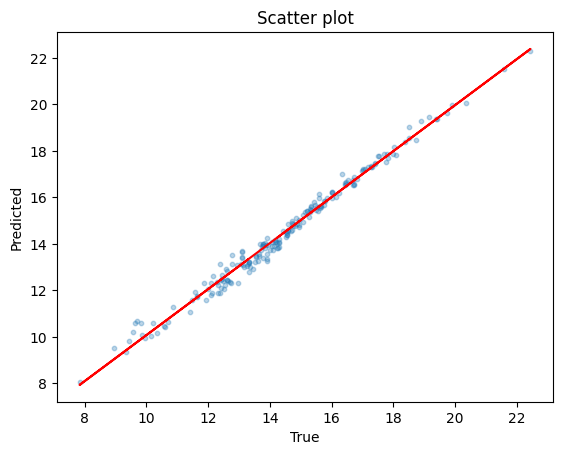

{'mae': 0.21617972216740397, 'medianae': 0.16962076635961054, 'mse': 0.07909473648269537, 'r2': 0.987023650233402, 'mape': 0.01623050121181705, 'mspe': np.float64(0.0005189570814592145), 'medianape': np.float64(0.011385174738001557)}


In [16]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, median_absolute_error
from sktime.performance_metrics.forecasting import mean_squared_percentage_error, median_absolute_percentage_error

# Evaluate our model
def plot_training_curves(history):
    """
    This function plots teh training and validation curves.

    I will use this function to see if the training went correctly and to check for possible over/under fitting of my
    model. If there is a sudden separation of the training and validation curves, that may indicate overfitting.

    Args:
        history (keras.history): history of my model
    """
    plt.figure(figsize=(8,5))
    plt.plot(history.history["loss"],label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title("Loss Curves")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (N^2)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_scatter(y_test, y_pred):
    """
    Plot the scatter plot with my test set

    This function plots the scatter plot of one of the set and the regression line to see how well our model fits
    the predictions

    Args:
        y_test (array): test set
        y_pred (array): predictions
    Returns:
        r2: R2 score
    """

    linear_regression = LinearRegression().fit(y_test.reshape(-1,1), y_pred.reshape(-1,1))
    y_fit = linear_regression.predict(y_test.reshape(-1,1))

    r2 = r2_score(y_pred, y_fit)

    plt.figure()
    plt.scatter(y_test, y_pred, label="Test", alpha=0.3, s=10)
    plt.plot(y_test, y_fit, "-r", label=f"Linear Fit (R^2 = {round(r2, 5)})")
    plt.title("Scatter plot")
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.show()

    return r2

# Como hemos escalado la información que teníamos, entonces trabajamos ahora sobre los datos escalados
y_pred_scaled = model.predict(x_test_scaled).flatten()
y_pred_scaled = np.array(y_pred_scaled).reshape(-1,1)

y_pred1 = y_scaler.inverse_transform(y_pred_scaled)
y_test1 = y_test

y_pred = np.exp(y_scaler.inverse_transform(y_pred_scaled))
y_test = np.exp(y_test)



def further_evaluation(y_test, y_pred, r2):
    """
    Calculate all the metrics

    This function is necessary to calculate all the metrics with the predictions
    on the test set. They are different from the metrics that you obtain while
    training and from which you could also extract information in case your training
    is not procceding as expected.

    Args:
       y_test (numpy_array): true values
       y_pred (numpy_array): predicted values
       r2 (float32): correlation coefficient

    Returns:    
       (dict): Dictionary containing the metrics
    """

    metrics = {
        "mae" : mean_absolute_error(y_test, y_pred),
        "medianae" : median_absolute_error(y_test, y_pred),
        "mse" : mean_squared_error(y_test, y_pred),
        "r2" : r2,
        "mape" : mean_absolute_percentage_error(y_test, y_pred),
        "mspe" : mean_squared_percentage_error(y_test, y_pred),
        "medianape" : median_absolute_percentage_error(y_test, y_pred)
    }
    return metrics 


plot_training_curves(history)
r2 = plot_scatter(y_test, y_pred)
metrics = further_evaluation(y_test, y_pred, r2)
print(metrics)
r21 = plot_scatter(y_test1, y_pred1)
metrics1 = further_evaluation(y_test1, y_pred1, r21)

print(metrics1)